### Laboratorium 6 - część projektowa

W tej części zajmiesz się wykorzystaniem punktów kluczowych do łączenia obrazów (_image stitching_). Celem zadania jest przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia obrazów. Istotne jest, by samodzielnie przejść całą ścieżkę: od detekcji punktów kluczowych i wyznaczenia ich desktryptorów, przez ich parowanie i znalezienie transformacji, po finalne połączenie obrazów. Rozwiązania oparte o gotowce w stylu black-box nie będą oceniane.

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być niemal dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy umożliwiały (1) użycie algorytmu SIFT, oraz (2) wykonanie transformacji geometrycznej.

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o ~połowę szerokości klatki),
* większe przesunięcie (o 3/4 szerokości lub więcej),
* przesunięcie z rotacją w osi kamery,
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3b) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary wynikowych obrazów są wystarczające do zmieszczenia obu składowych.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jeśli dla którejś pary metoda zawiodła, to dlaczego?*  
*Jaka była jakość dopasowania? Na jakiej podstawie ją określasz?*

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Processing dla jednego obrazu
def process_offset_image(offset_img, base_img, kp_base, des_base, threshold):
    sift = cv2.SIFT_create()
    kp_offset, des_offset = sift.detectAndCompute(offset_img, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des_base, des_offset)

    matches = sorted(matches, key=lambda x: x.distance)

    if threshold != None:
        filtered_matches = [m for m in matches if m.distance < threshold]
    else:
        filtered_matches = matches

    dst_pts = np.float32([kp_base[m.queryIdx].pt for m in filtered_matches]).reshape(-1, 1, 2)
    src_pts = np.float32([kp_offset[m.trainIdx].pt for m in filtered_matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    det_M = np.linalg.det(M)

    h, w, _ = base_img.shape
    aligned_img = cv2.warpPerspective(offset_img, M, (w, h))

    return aligned_img, kp_offset, filtered_matches, mask, det_M


def visualize_results(base, offset_img, aligned_img, kp_base, kp_offset, filtered_matches, mask, img_index):
    f, axes = plt.subplots(2, 2, figsize=(16, 8))

    axes[0, 0].imshow(base[..., ::-1])
    axes[0, 0].set_title("Base Image")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(offset_img[..., ::-1])
    axes[0, 1].set_title(f"Original Offset Image {img_index}")
    axes[0, 1].axis('off')

    axes[1, 0].imshow(aligned_img[..., ::-1])
    axes[1, 0].set_title(f"Aligned Offset Image {img_index}")
    axes[1, 0].axis('off')

    overlay = cv2.addWeighted(base, 0.5, aligned_img, 0.5, 0)
    axes[1, 1].imshow(overlay[..., ::-1])
    axes[1, 1].set_title(f"Overlay of Base and Aligned Offset Image {img_index}")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Wyświetlenie dopasowań z wyróżnieniem inlierów
    matches_mask = mask.ravel().tolist()
    inlier_image = cv2.drawMatches(
        base, kp_base, offset_img, kp_offset, filtered_matches, None,
        matchColor=(0, 255, 0), singlePointColor=(255, 0, 0),
        matchesMask=matches_mask
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(inlier_image[..., ::-1])
    plt.title(f"Inlier Matches for Offset Image {img_index} (Inliers={sum(matches_mask)}, Total Matches={len(filtered_matches)})")
    plt.axis('off')
    plt.show()


def process_and_visualize_images(base, offset_imgs, threshold):
    sift = cv2.SIFT_create()
    kp_base, des_base = sift.detectAndCompute(base, None)

    for i, offset_img in enumerate(offset_imgs):
        print(f"Offset image number: {i+1}")
        result = process_offset_image(offset_img, base, kp_base, des_base, threshold=threshold)

        aligned_img, kp_offset, filtered_matches, mask, det_M = result
        print(f"Wyznacznik macierzy przekształcenia: {det_M}")
        visualize_results(base, offset_img, aligned_img, kp_base, kp_offset, filtered_matches, mask, i+1)

Offset image number: 1
Wyznacznik macierzy przekształcenia: 0.8214366545066616


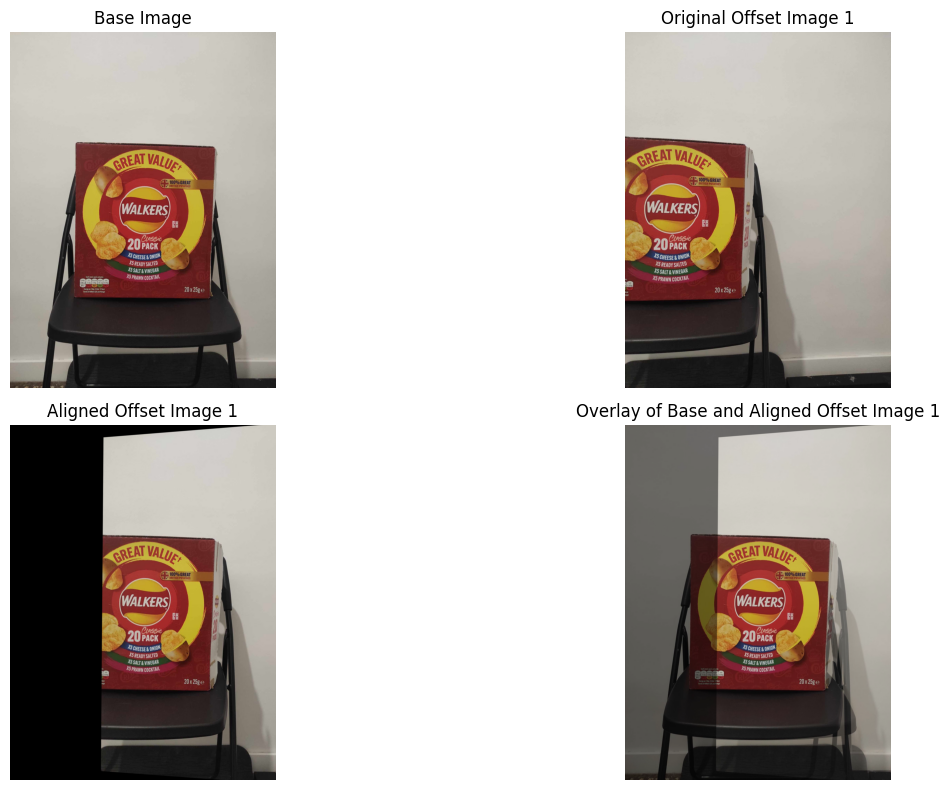

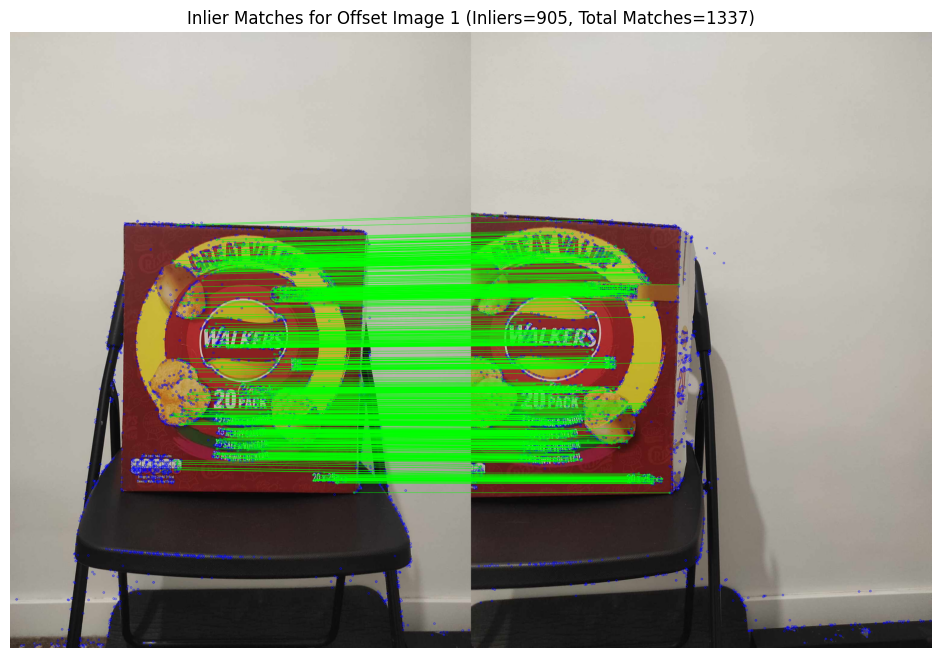

Offset image number: 2
Wyznacznik macierzy przekształcenia: 0.775444589232775


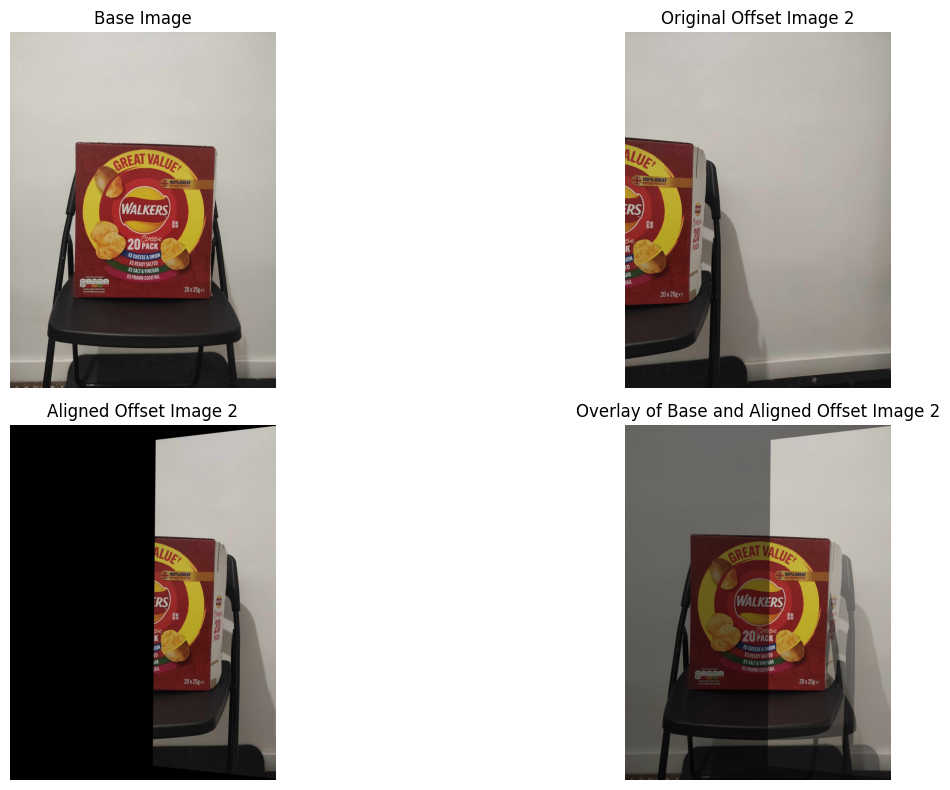

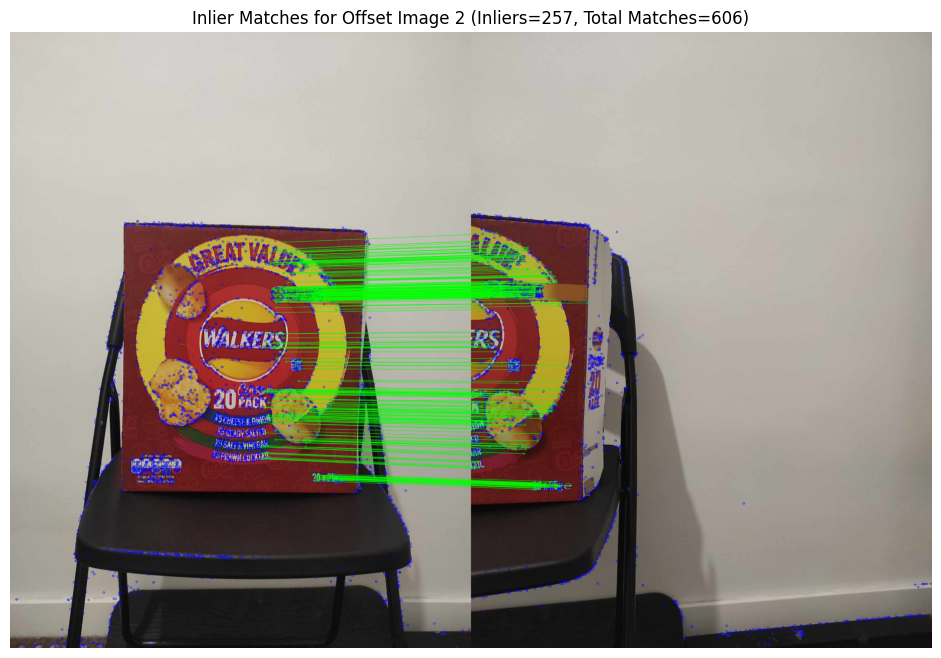

Offset image number: 3
Wyznacznik macierzy przekształcenia: 1.0561738385548027


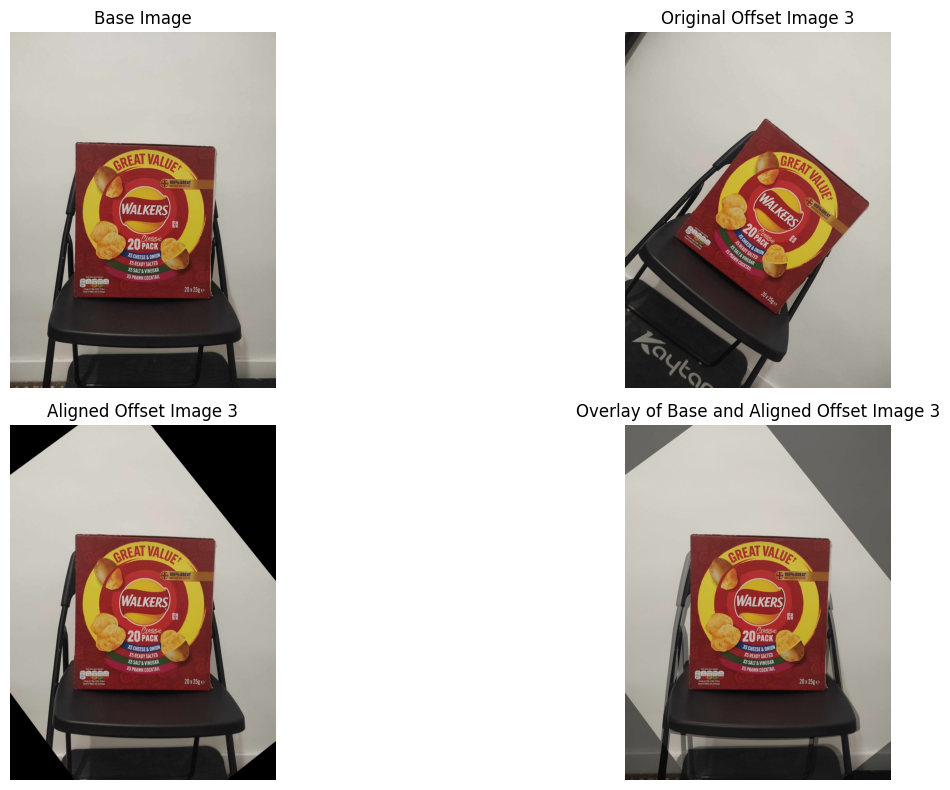

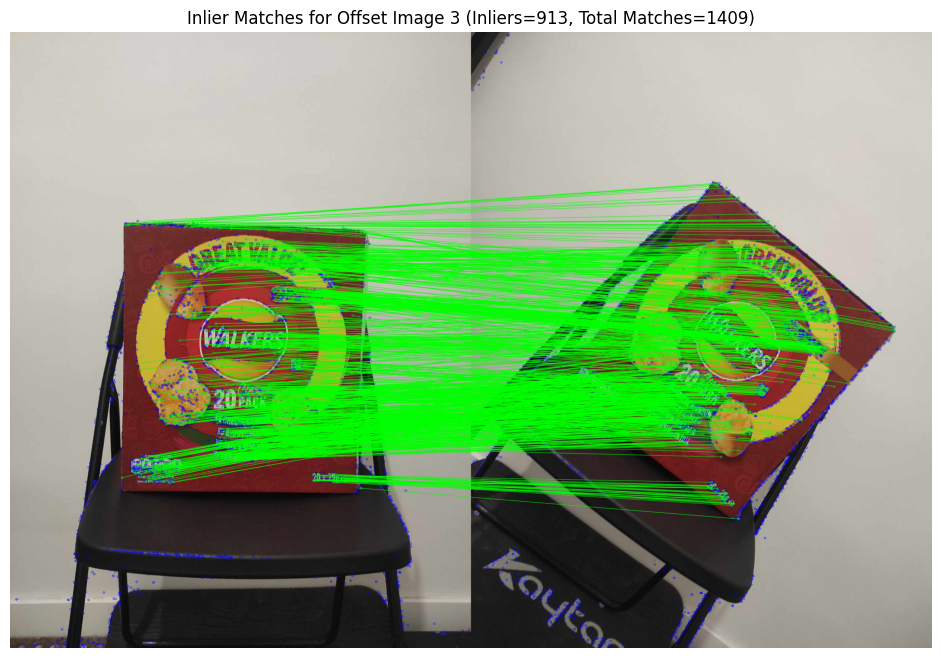

Offset image number: 4
Wyznacznik macierzy przekształcenia: 0.1424584628245335


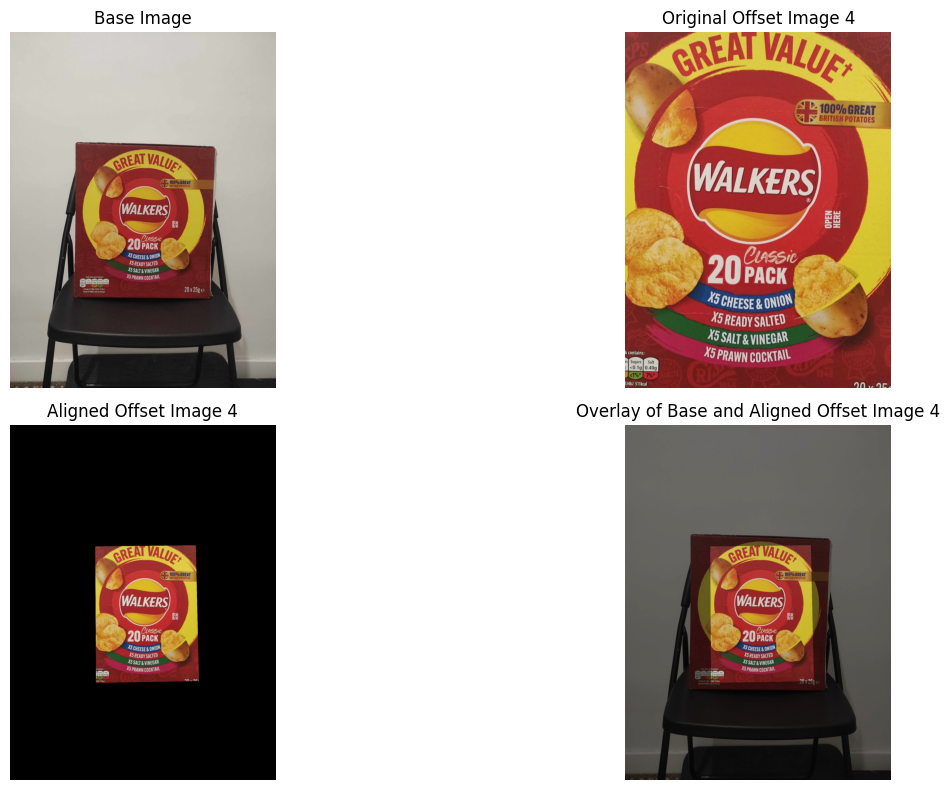

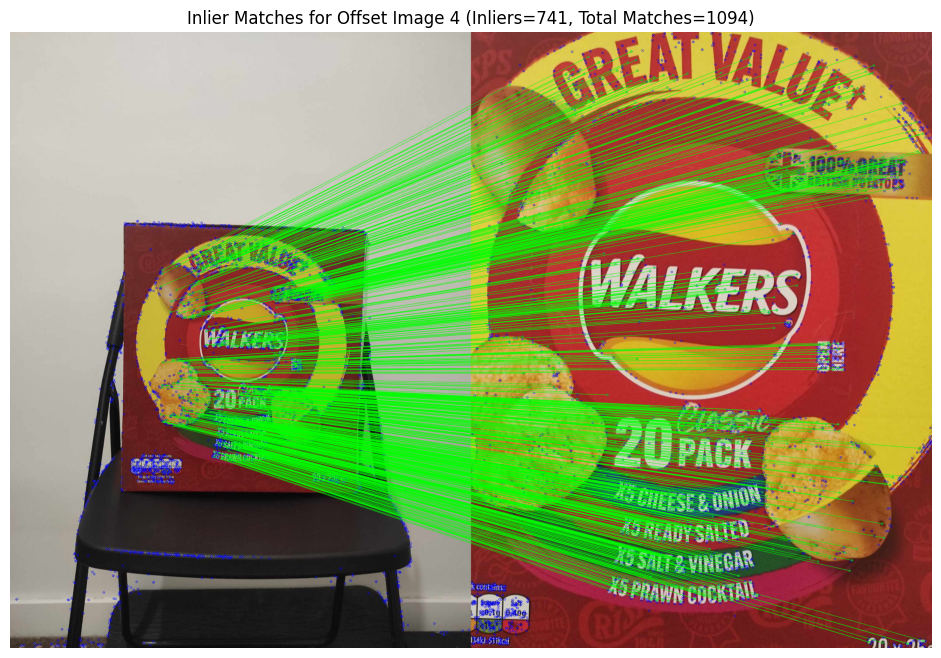

In [31]:
base = cv2.imread('lays/lays0.jpg')
offset_imgs = [
    cv2.imread('lays/lays1.jpg'),
    cv2.imread('lays/lays2.jpg'),
    cv2.imread('lays/lays3.jpg'),
    cv2.imread('lays/lays4.jpg'),
]

threshold = 200
process_and_visualize_images(base, offset_imgs, threshold)